# Detect AI vs Human generated images
In this notebook, I aim to build a convnet architecture for detecting real images from fake ones.

In [3]:
# All imports needed for this classification project
import kagglehub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import ResNet152, Xception
from tensorflow.keras.applications.resnet import preprocess_input

In [4]:
# Reproducability
def set_seed(seed=44):
    np.random.seed(seed)
    tf.random.set_seed(seed)
set_seed()

In [5]:
# Download latest version
data_path = kagglehub.dataset_download("alessandrasala79/ai-vs-human-generated-dataset")

print("Path to dataset files:", data_path)

Path to dataset files: /kaggle/input/ai-vs-human-generated-dataset


In [6]:
# Csv files with paths to the images
train = pd.read_csv(data_path+"/"+"train.csv", index_col=0)
test = pd.read_csv(data_path+"/"+"test.csv")

In [7]:
print(train.head())

                                         file_name  label
0  train_data/a6dcb93f596a43249135678dfcfc17ea.jpg      1
1  train_data/041be3153810433ab146bc97d5af505c.jpg      0
2  train_data/615df26ce9494e5db2f70e57ce7a3a4f.jpg      1
3  train_data/8542fe161d9147be8e835e50c0de39cd.jpg      0
4  train_data/5d81fa12bc3b4cea8c94a6700a477cf2.jpg      1


In [8]:
def create_image_fullpath(file_path, labels=None):
    """
    Creates an array with full path to the images.
    Labels array created where appropriate.
    """
    full_path = [data_path +"/"+ image_path for image_path in file_path]
    full_path = np.array(full_path)
    if labels is not None:
        labels = np.array(labels)
        return full_path, labels
    else:
        return full_path

In [9]:
# Creates full paths to images
train_full_path, labels = create_image_fullpath(train["file_name"], train["label"])
test_full_path = create_image_fullpath(test["id"])

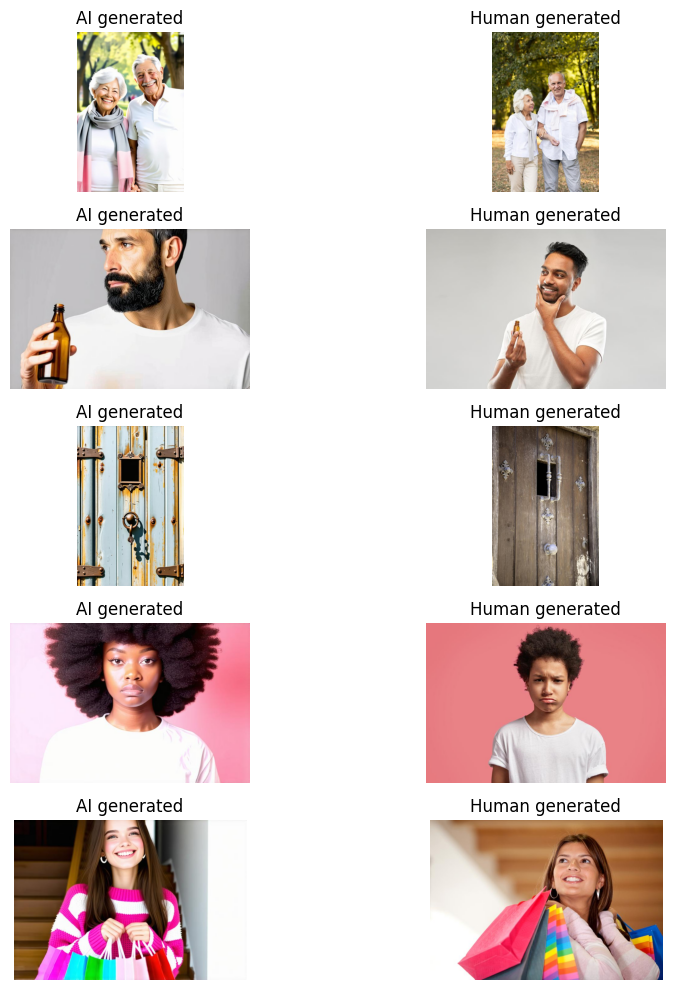

In [10]:
# Visualize the the first ten images. 
fig, ax = plt.subplots(5, 2, figsize=(10,10))

index = 0
for i in range(5):
    for j in range(2):
        im = plt.imread(train_full_path[index])
        ax[i][j].imshow(im)
        ax[i][j].axis("off")
        
        if labels[index] == 0:
            ax[i][j].set_title("Human generated")
        else:
            ax[i][j].set_title("AI generated")
            
        index += 1

                  
fig.tight_layout()

Based on the above visualizations, it's evidented the data isn't shuffled and image sizes are different.

In [11]:
# Shuffle train data
indices = np.random.permutation(len(train_full_path))
train_full_path, labels = train_full_path[indices], labels[indices]

In [16]:
def visualize(original, augmented):
    fig = plt.figure()
    plt.subplot(1,2,1)
    plt.title('Original image')
    plt.imshow(original)
    plt.axis("off")
    
    plt.subplot(1,2,2)
    plt.title('Augmented image')
    plt.imshow(augmented)
    plt.axis("off")


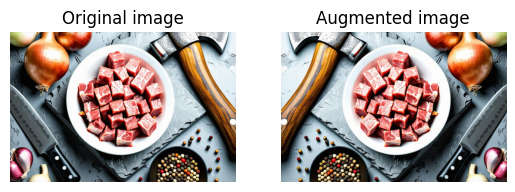

In [17]:
image = plt.imread(train_full_path[0])
flipped = tf.image.flip_left_right(image)
visualize(image, flipped)

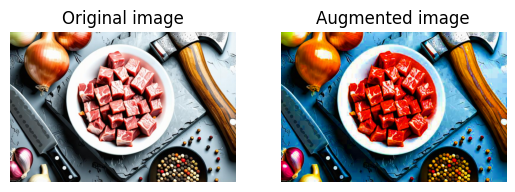

In [23]:
saturated = tf.image.adjust_saturation(image, 5)
visualize(image, saturated)

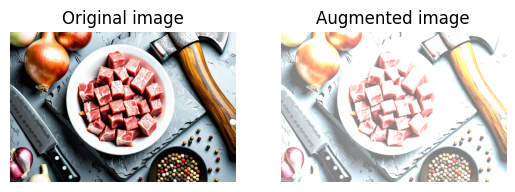

In [27]:
bright = tf.image.adjust_brightness(image, 0.5)
visualize(image, bright)

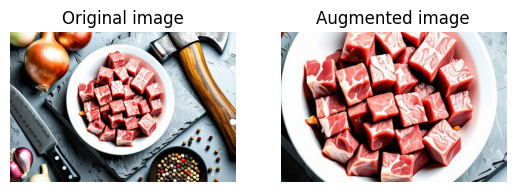

In [31]:
cropped = tf.image.central_crop(image, central_fraction=0.5)
visualize(image, cropped)

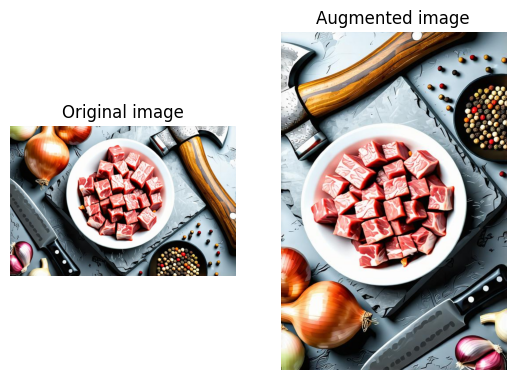

In [32]:
rotated = tf.image.rot90(image)
visualize(image, rotated)

In [10]:
# Split train into train and validation data
X_train, X_val, y_train, y_val = train_test_split(train_full_path, 
                                                  labels,
                                                  test_size=0.2,
                                                  random_state=44)

In [43]:
# I'll convert the numpy arrays to tensorflow dataset

train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val))

In [44]:
# Apply the data processing on the tf dataset
train_ds = train_ds.map(load_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.map(load_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)

# Batch the dataset
batch_size = 30
train_ds = train_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

Tensor("resize/Squeeze:0", shape=(224, 224, 3), dtype=float32)
Tensor("resize/Squeeze:0", shape=(224, 224, 3), dtype=float32)


In [45]:
for i, j in train_ds:
    print(i)
    break

UnknownError: {{function_node __wrapped__IteratorGetNext_output_types_2_device_/job:localhost/replica:0/task:0/device:CPU:0}} error: OpenCV(4.10.0) :-1: error: (-5:Bad argument) in function 'dilate'
> Overload resolution failed:
>  - src is not a numpy array, neither a scalar
>  - Expected Ptr<cv::UMat> for argument 'src'

Traceback (most recent call last):

  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/ops/script_ops.py", line 268, in __call__
    return func(device, token, args)

  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/ops/script_ops.py", line 146, in __call__
    outputs = self._call(device, args)

  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/ops/script_ops.py", line 153, in _call
    ret = self._func(*args)

  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/autograph/impl/api.py", line 643, in wrapper
    return func(*args, **kwargs)

  File "<ipython-input-42-f4934d764b6c>", line 4, in opencv_preprocessing
    dilated_image = cv2.dilate(image, kernel, iterations=2)

cv2.error: OpenCV(4.10.0) :-1: error: (-5:Bad argument) in function 'dilate'
> Overload resolution failed:
>  - src is not a numpy array, neither a scalar
>  - Expected Ptr<cv::UMat> for argument 'src'



	 [[{{node EagerPyFunc}}]] [Op:IteratorGetNext] name: 

In [ ]:
pretrained_base = ResNet152(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
avg = keras.layers.GlobalAveragePooling2D()(pretrained_base.output)
output = keras.layers.Dense(2, activation="softmax")(avg)
model = keras.models.Model(inputs=pretrained_base.input, outputs=output)

In [ ]:
for layer in pretrained_base.layers:
    layer.trainable = False

model.compile(loss="sparse_categorical_crossentropy", optimizer="adam",
              metrics=["accuracy"])
history = model.fit(train_ds,
                    steps_per_epoch=int(0.75 * len(train_ds) / batch_size),
                    validation_data=val_ds,
                    validation_steps=int(0.15 * len(train_ds) / batch_size),
                    epochs=5, 
                    verbose=1)

In [ ]:
for layer in pretrained_base.layers:
    layer.trainable = True

model.compile(loss="sparse_categorical_crossentropy", optimizer="adam",
              metrics=["accuracy"])
history = model.fit(train_ds,
                    steps_per_epoch=int(0.75 * len(train_ds) / batch_size),
                    validation_data=val_ds,
                    validation_steps=int(0.15 * len(train_ds) / batch_size),
                    epochs=5, 
                    verbose=1)

In [ ]:
# model = keras.Sequential([
#     pretrained_base,
#     layers.GlobalAveragePooling2D(), 
#     layers.Dense(128, activation='relu', kernel_regularizer=l2(0.01)),  
#     layers.Dropout(0.5), 
#     layers.Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
#     layers.Dropout(0.3), 
#     layers.Dense(1, activation='sigmoid')  
# ])

In [ ]:
# model.compile(
#     optimizer='adam',
#     loss='binary_crossentropy',
#     metrics=['binary_accuracy'],
# )

# history = model.fit(
#     train_ds,
#     validation_data=val_ds,
#     epochs=5,
#     verbose=1,
# )

In [ ]:
history_frame

In [ ]:
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['accuracy', 'val_accuracy']].plot();

In [ ]:
test_data = tf.data.Dataset.from_tensor_slices(test_full_path)
test_data = test_data.map(load_preprocess_image_1, num_parallel_calls=tf.data.AUTOTUNE)
test_data = test_data.batch(batch_size)

In [ ]:
pred = model.predict(test_data)

In [ ]:
ar = [0 if i > 0.5 else 1 for i,j in pred]

In [ ]:
test["label"] = ar
test.to_csv("predictions.csv", index=False)